### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [59]:
# Dependencies and Setup
import pandas as pd
from datetime import datetime
import os
import glob
import numpy as np

#Custom Calls
import DD_Process_Incident_Details as dp
import DD_Get_Victim_Counts as gpc


## Player Count

In [60]:
## DD PART I 
## FILE IMPORT 

dd_file = "resource/gun-violence-data_01-2013_03-2018 2.csv"
dd_file_df = pd.read_csv(dd_file)

# A sub df created with the columns which targeted to be processed
dd_participant_vdf = dd_file_df[['incident_id','participant_age_group','participant_gender','participant_type','participant_status']]
dd_participant_vdf.reset_index

dd_participant_vdf = dd_participant_vdf.dropna()
dd_participant_vdf.reset_index(level=None, drop=False, inplace=True, col_level=0, col_fill='')

dd_participant_vdf.head()



,index,incident_id,participant_age_group,participant_gender,participant_type,participant_status
0,0,461105,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Victim||1::Victim||2::Victim||3::Victim||4:...,0::Arrested||1::Injured||2::Injured||3::Injure...
1,1,460726,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Victim||1::Victim||2::Victim||3::Victim||4:...,0::Killed||1::Injured||2::Injured||3::Injured
2,2,478855,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Subject-Suspect||1::Subject-Suspect||2::Vic...,"0::Injured, Unharmed, Arrested||1::Unharmed, A..."
3,3,478925,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Victim||1::Victim||2::Victim||3::Subject-Su...,0::Killed||1::Killed||2::Killed||3::Killed
4,4,478959,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Victim||1::Victim||2::Victim||3::Subject-Su...,0::Injured||1::Injured||2::Killed||3::Killed


In [61]:
## DD PART II
## DATA PROCESSING

#
# CALCULATING SUSPECT AND VICTIM COUNT
#

dd_l_victim = gpc.get_count(dd_participant_vdf['participant_type'],'Victim')
dd_l_suspect = gpc.get_count(dd_participant_vdf['participant_type'],'Suspect')


dd_participant_vdf = dd_participant_vdf.assign(Victim_Count=dd_l_victim)
dd_participant_vdf = dd_participant_vdf.assign(Suspect_Count=dd_l_suspect)


#
#  PROCESSING DATA INTO ROWS, CREATING INVOICE DETAILS DF
#

# Chunks are created to create sample data faster. The whole set runs about 50 minutes to process
dd_S = 40000
dd_N = int(len(dd_participant_vdf)/dd_S)
dd_frames = [ dd_participant_vdf.iloc[i*dd_S:(i+1)*dd_S].copy() for i in range(dd_N+1) ]


#Calling custom python file to convert to data stored in series to rows.
i=0
p_dd_flag = False #50 min total time . Turn it on only when you want to process the data again.
if p_dd_flag == True:
    for dframe in dd_frames:

        dd_date_time = datetime.now().strftime("%m%d%Y")
        dd_file_name =f"dd_incident_details_{str(dd_date_time)}_{i}"
        print("file name:",dd_file_name)
        p_dd_debug = False
        i+=1


        p_dd_debug = False
        p_val = dp.process_data(dframe['incident_id'], 
                        dframe['participant_type'],
                        dframe["participant_gender"],
                        dframe["participant_status"],
                        dframe["participant_age_group"],
                        dd_file_name,                
                        p_dd_debug
                    )


#
# MERGING MULTIPLE FILES CREATED IN THE CHUNKS INTO SINGLE DATA FRAME
#

# I choose to create data in chunks, therefore I merged the created csv files and created a single dataframe for the result.
dd_dir_path = "resource"

dd_joined_files = os.path.join(dd_dir_path, "dd_incident_details*.csv")

# A list of all joined files is returned
dd_joined_list = glob.glob(dd_joined_files)
  
# Finally, the files are joined
dd_merged_df = pd.concat(map(pd.read_csv, dd_joined_list), ignore_index=True)
dd_merged_df = dd_merged_df.dropna()

dd_merged_df.reset_index(level=None, drop=False, inplace=True, col_level=0, col_fill='')
del dd_merged_df['index']


dd_merged_df.head()


,incident_id,No,Type,Status,Age Group,Gender
0,461105,0,Victim,Arrested,Adult 18+,Male
1,461105,1,Victim,Injured,Adult 18+,Male
2,461105,3,Victim,Injured,Adult 18+,Male
3,461105,4,Subject-Suspect,Injured,Adult 18+,Female
4,460726,0,Victim,Killed,Adult 18+,Male


In [62]:
## DD PART III
## DATA CLEANING 

#### OPTIONAL EXTRACTING DATA TO CSV TO AVOID PROCESSING TIMES
#Not necessary but I extracted the data to csv file for my internal work. 
dd_date_time = datetime.now().strftime("%m%d%Y")
dd_file_name = f"{dd_dir_path}\dd_incident_details_master_file{dd_date_time}.csv"
dd_merged_df.to_csv(dd_file_name, index=False, header=True)     
#### OPTIONAL EXTRACTING DATA TO CSV TO AVOID PROCESSING TIMES


# DATA CLEANING 
dd_merged_df['Gender'] = dd_merged_df['Gender'].replace({'ale': 'Male', 'emale': 'Female','Mal':'Male'})
dd_merged_df['Type'] = dd_merged_df['Type'].replace({'ictim': 'Victim', 'ubject-Suspect': 'Subject-Suspect'})
dd_merged_df['Age Group'] = dd_merged_df['Age Group'].replace({'dult 18+': 'Adult 18+', 'een 12-17': 'Teen 12-17','hild 0-11': 'Child 0-11'})


dd_victim_df = dd_merged_df.loc[dd_merged_df["Type"] == 'Victim']
dd_victim_df.reset_index(level=None, drop=False, inplace=True, col_level=0, col_fill='')
dd_suspect_df = dd_merged_df.loc[dd_merged_df["Type"] != 'Victim']
dd_suspect_df.reset_index(level=None, drop=False, inplace=True, col_level=0, col_fill='')
dd_nonadult_df = dd_merged_df.loc[dd_merged_df["Age Group"] != 'Adult 18+']
dd_nonadult_df.reset_index(level=None, drop=False, inplace=True, col_level=0, col_fill='')

print("Victim Data Frame: \n")
print(f"{dd_victim_df.head()}\n")

print("Suspect Data Frame: \n")
print(f"{dd_suspect_df.head()}\n")

print("Teenage and Child Data Frame: \n")
print(f"{dd_nonadult_df.head()}\n")


Victim Data Frame: 

   index  incident_id  No    Type    Status  Age Group Gender
0      0       461105   0  Victim  Arrested  Adult 18+   Male
1      1       461105   1  Victim   Injured  Adult 18+   Male
2      2       461105   3  Victim   Injured  Adult 18+   Male
3      4       460726   0  Victim    Killed  Adult 18+   Male
4      7       478855   2  Victim    Killed  Adult 18+   Male

Suspect Data Frame: 

   index  incident_id  No             Type                       Status  \
0      3       461105   4  Subject-Suspect                      Injured   
1      5       478855   0  Subject-Suspect  Injured, Unharmed, Arrested   
2      6       478855   1  Subject-Suspect           Unharmed, Arrested   
3     13       478925   3  Subject-Suspect                       Killed   
4     17       478959   3  Subject-Suspect                       Killed   

   Age Group  Gender  
0  Adult 18+  Female  
1  Adult 18+    Male  
2  Adult 18+    Male  
3  Adult 18+    Male  
4  Adult 18+  Fema

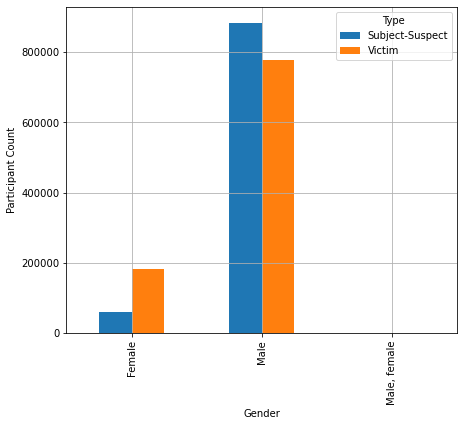

In [63]:
# DD GRAPH I

df_pivot = pd.pivot_table(
	dd_merged_df,
	values="incident_id",
	index="Gender",
	columns="Type",
	aggfunc=np.count_nonzero
)


ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()

fig.set_size_inches(7, 6)

ax.set_xlabel("Gender")
ax.set_ylabel("Participant Count")


ax.grid()
fig.savefig("Gender_Type_1.png")



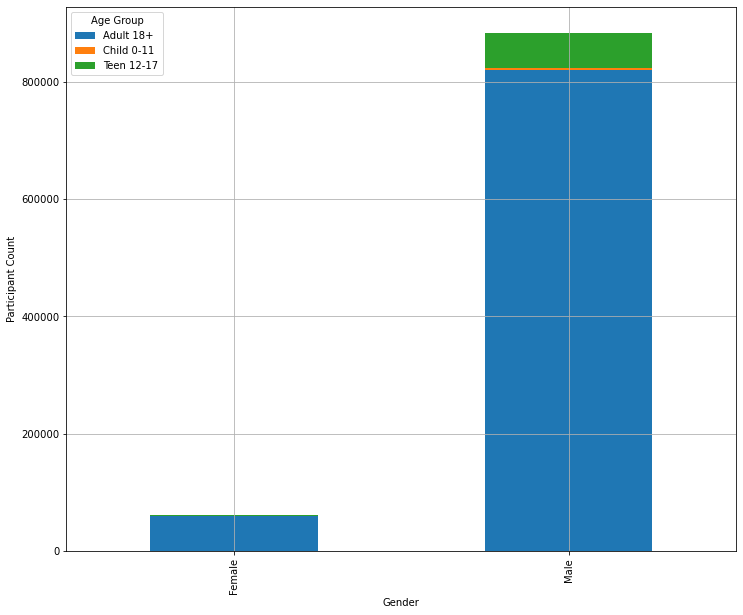

In [64]:
# DD GRAPH II

df_pivot2 = pd.pivot_table(
	dd_suspect_df,
	values="incident_id",
	index="Gender",
	columns="Age Group",
	aggfunc=np.count_nonzero
)


ax2 = df_pivot2.plot(kind="bar",stacked=True)
fig2 = ax2.get_figure()

fig2.set_size_inches(12, 10)

ax2.set_xlabel("Gender")
ax2.set_ylabel("Participant Count")


ax2.grid()
fig2.savefig("Gender_Type_2.png")

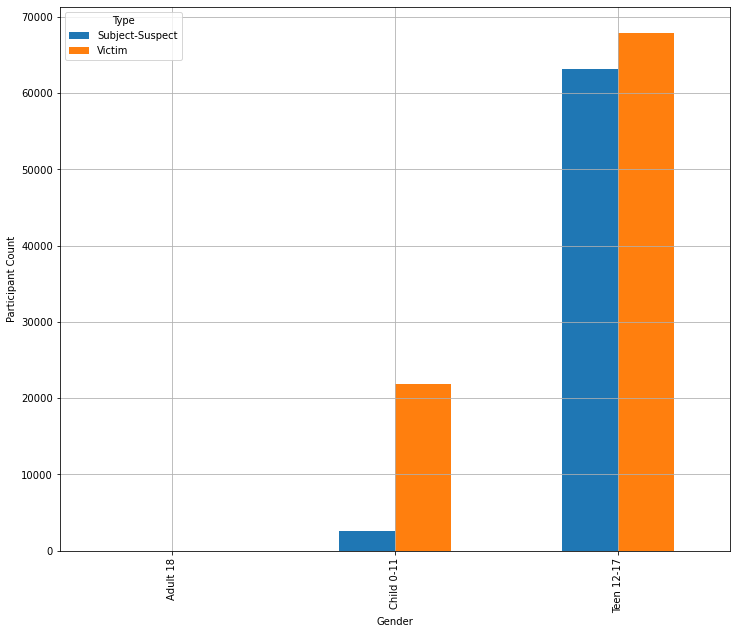

In [65]:
# DD GRAPH III

df_pivot3 = pd.pivot_table(
	dd_nonadult_df,
	values="incident_id",
	index="Age Group",
	columns="Type",
	aggfunc=np.count_nonzero
)


ax3 = df_pivot3.plot(kind="bar")
fig3 = ax3.get_figure()

fig3.set_size_inches(12, 10)

ax3.set_xlabel("Gender")
ax3.set_ylabel("Participant Count")


ax3.grid()
fig3.savefig("Gender_Type_3.png")